In [1]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [2]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [3]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [4]:
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
    # encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
# one hot encode target sequence

In [5]:
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [6]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


In [7]:
# load datasets
dataset = load_clean_sentences('english-dari-both.pkl')
train = load_clean_sentences('english-dari-train.pkl')
test = load_clean_sentences('english-dari-test.pkl')

In [10]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 3687
English Max Length: 1


In [11]:
# prepare Dari tokenizer
dari_tokenizer = create_tokenizer(dataset[:, 1])
dari_vocab_size = len(dari_tokenizer.word_index) + 1
dari_length = max_length(dataset[:, 1])
print('Dari Vocabulary Size: %d' % dari_vocab_size)
print('Dari Max Length: %d' % (dari_length))

Dari Vocabulary Size: 2736
Dari Max Length: 8


In [12]:
# prepare training data
trainX = encode_sequences(dari_tokenizer, dari_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

In [13]:
# prepare validation data
testX = encode_sequences(dari_tokenizer, dari_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [14]:
# define model
model = define_model(dari_vocab_size, eng_vocab_size, dari_length, eng_length, 256)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 256)            700416    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 3687)           947559    
Total params: 2,698,599
Trainable params: 2,698,599
Non-trainable params: 0
_________________________________________________________________


In [15]:
# fit model
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1,
save_best_only=True, mode='min')

In [16]:
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY),
callbacks=[checkpoint], verbose=2)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 7.10345, saving model to model.h5
141/141 - 11s - loss: 7.6818 - val_loss: 7.1034
Epoch 2/30

Epoch 00002: val_loss improved from 7.10345 to 6.62214, saving model to model.h5
141/141 - 9s - loss: 6.7437 - val_loss: 6.6221
Epoch 3/30

Epoch 00003: val_loss improved from 6.62214 to 5.88953, saving model to model.h5
141/141 - 9s - loss: 5.8786 - val_loss: 5.8895
Epoch 4/30

Epoch 00004: val_loss improved from 5.88953 to 5.19342, saving model to model.h5
141/141 - 9s - loss: 4.8719 - val_loss: 5.1934
Epoch 5/30

Epoch 00005: val_loss improved from 5.19342 to 4.73711, saving model to model.h5
141/141 - 9s - loss: 3.9821 - val_loss: 4.7371
Epoch 6/30

Epoch 00006: val_loss improved from 4.73711 to 4.44459, saving model to model.h5
141/141 - 9s - loss: 3.2744 - val_loss: 4.4446
Epoch 7/30

Epoch 00007: val_loss improved from 4.44459 to 4.32098, saving model to model.h5
141/141 - 10s - loss: 2.7105 - val_loss: 4.3210
Epoch 8/30

Epoch 0000

In [17]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [18]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [20]:
from keras.models import load_model

# load datasets
dataset = load_clean_sentences('english-dari-both.pkl')
train = load_clean_sentences('english-dari-train.pkl')
test = load_clean_sentences('english-dari-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
dari_tokenizer = create_tokenizer(dataset[:, 1])
dari_vocab_size = len(dari_tokenizer.word_index) + 1
dari_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(dari_tokenizer, dari_length, train[:, 1])
testX = encode_sequences(dari_tokenizer, dari_length, test[:, 1])
# load model
model = load_model('model.h5')

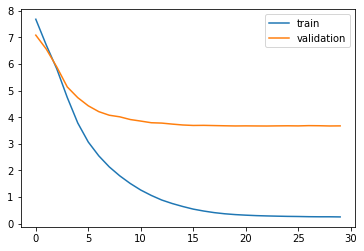

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [24]:
model = load_model('model.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [25]:
# change predictiton to coresponding words
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [26]:
# Convert predictions into text (English):

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [27]:
# Let’s put the original English sentences in the test dataset and the predicted sentences in a dataframe:
import pandas as pd
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [28]:
# print 15 rows randomly
pred_df.sample(15)

actual   predicted
398     رفتن       going
401     شخصی  individual
56   پسندیدن        like
553  غلبه بر    overcome
383      بار       times
769      فصل     chapter
892  افسردگی  depression
260      یکی         one
112    زندگی        life
831    کیفیت    familiar
889  هر چیزی    anything
298     هنوز       still
351   هدف شی        cash
64     شخصیت   character
735    بورلی  apparently